# Generalized Method of Moments

In [9]:
import numpy as np
import pandas as pd
import scipy.stats as sts
import matplotlib.pyplot as plt
import scipy.optimize as opt

import scipy.stats as sts
from scipy.stats import lognorm

import seaborn as sns

#
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr

sns.set_palette("pastel")
# This next command is specifically for Jupyter Notebook
%matplotlib notebook

1b.
mu_GMM: 11.33 sig_GMM: 0.21
The value of the GMM criterion function: 1.527969312041055e-15
Data moments: mu: 85276.82, std: 17992.54
Model moments: mu: 85276.83, std: 17992.54



<IPython.core.display.Javascript object>


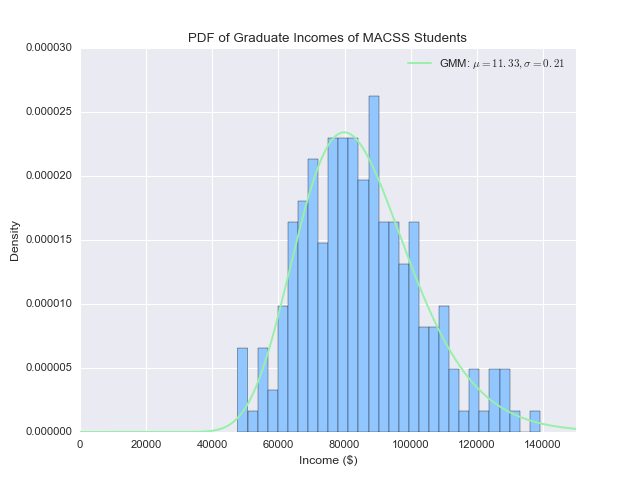

In [10]:
# (a) Plot a histogram of percentages of the income.txt data with 30 bins. 
# (b) Estimate the parameters of the lognormal distribution by GMM. 
# Use the average income and standard deviation of income as your two moments. 
# Use the identity matrix as your weighting matrix Wˆ . Plot your estimated lognormal PDF 
# against the histogram from part (a). 
# Report the value of your GMM criterion function at the estimated parameter values. 
# Report and compare your two data moments against your two model moments at the estimated parameter values.

income = np.loadtxt('incomes.txt')

# These values can be generated from observing (a)
cutoff = 150000
lower_bound = 0.00
upper_bound = 150000
nums = 150000

def trunc_lognorm_pdf(xvals, mu, sigma, cutoff):
    '''
    --------------------------------------------------------------------
    Generate lognormal pdf values from the truncated normal pdf 
    with mean mu and standard deviation sigma. If the cutoff is finite, 
    then the PDF values are inflated upward to reflect the zero probability
    on values above the cutoff. 
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, values of the normally distributed random
             variable
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    RETURNS: pdf_vals
    --------------------------------------------------------------------
    '''
    if cutoff == 'None':
        prob_notcut = 1.0
    else:
        prob_notcut = sts.norm.cdf(cutoff, loc=mu, scale=sigma)
    
    lognorm_pdf_vals = ((1/(xvals*sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2))) /
                    prob_notcut)
    
    return lognorm_pdf_vals

def data_moments(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the two data moments for GMM
    (mean(data), standard deviation(data)).
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, test scores data
    
    RETURNS: mean_data, std_data
    --------------------------------------------------------------------
    '''
    mean_data = xvals.mean()
    std_data = xvals.std()
    
    return mean_data, std_data

def model_moments(mu, sigma, cutoff):
    '''
    --------------------------------------------------------------------
    This function computes the two model moments for GMM
    (mean(model data), standard deviation(model data)).
    --------------------------------------------------------------------
    INPUTS:
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    RETURNS: mean_model, std_model
    --------------------------------------------------------------------
    '''
    xfx = lambda x: x * trunc_lognorm_pdf(x, mu, sigma, cutoff)
    (mean_model, m_m_err) = intgr.quad(xfx, 0, 15000000) 
    x2fx = lambda x: ((x - mean_model) ** 2) * trunc_lognorm_pdf(x, mu, sigma,
                                                                 cutoff) 
    (var_model, v_m_err) = intgr.quad(x2fx, 0, 15000000)
    std_model = np.sqrt(var_model)
    s_m_err = np.sqrt(v_m_err)
    
    return mean_model, std_model



def err_vec(xvals, mu, sigma, cutoff, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    mean_data, std_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [std_data]])
    mean_model, std_model = model_moments(mu, sigma, cutoff)
    moms_model = np.array([[mean_model], [std_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec


def criterion(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 3 tuple, (xvals, cutoff, W_hat) # waiting matrix 
    xvals  = (N,) vector, values of the truncated normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    W_hat  = (R, R) matrix, estimate of optimal weighting matrix
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, cutoff, W = args
    err = err_vec(xvals, mu, sigma, cutoff, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 

    return crit_val


mu_init, sig_init = 11.0, 0.2

params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (income, 150000, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B',
                       bounds=((1e-10, None), (1e-10, None)))

mu_GMM1, sig_GMM1 = results.x

params_GMM1 = np.array([mu_GMM1, sig_GMM1])
value1 = criterion(params_GMM1, *gmm_args)[0,0]

mean_data, std_data = data_moments(income)
mean_model, std_model = model_moments(mu_GMM1, sig_GMM1, 150000)

print('1b.')
print('mu_GMM: {:.2f}'.format(mu_GMM1), 'sig_GMM: {:.2f}'.format(
       sig_GMM1))
print('The value of the GMM criterion function: {}'.format(value1))
print('Data moments: mu: {:.2f}, std: {:.2f}'.format(mean_data, std_data))
print('Model moments: mu: {:.2f}, std: {:.2f}\n'.format(mean_model, std_model))

dist_income = np.linspace(lower_bound, upper_bound, nums)

fig, ax = plt.subplots()
count, bins, ignored = plt.hist(income, 30, normed = True)

plt.title('PDF of Graduate Incomes of MACSS Students')
plt.xlabel(r'Income ($)')
plt.ylabel('Density')

plt.plot(dist_income, trunc_lognorm_pdf(dist_income, mu_GMM1, sig_GMM1,
            150000), label = 'GMM: $\mu = {:.2f}, \sigma = {:.2f}$'.format(
                mu_GMM1, sig_GMM1))

plt.xlim(0, cutoff)
plt.legend(loc='best')

<IPython.core.display.Javascript object>


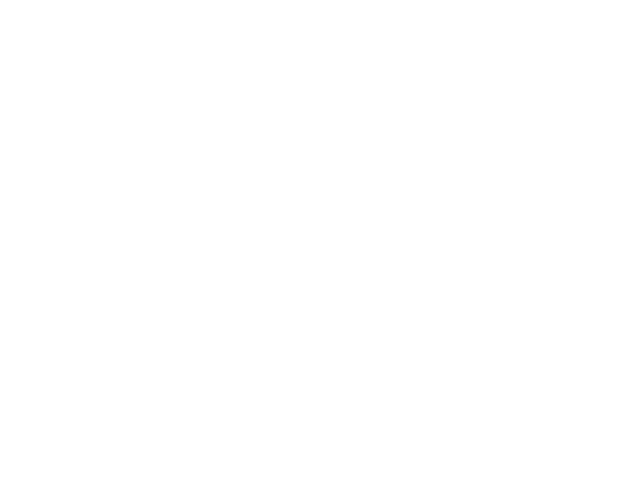

1c.
mu_GMM: 11.33 sig_GMM: 0.21
The value of the GMM criterion function: 2.1285610191427995e-05
Data moments: mu: 85276.82, std: 17992.54
Model moments: mu: 85276.83, std: 17992.54



<IPython.core.display.Javascript object>


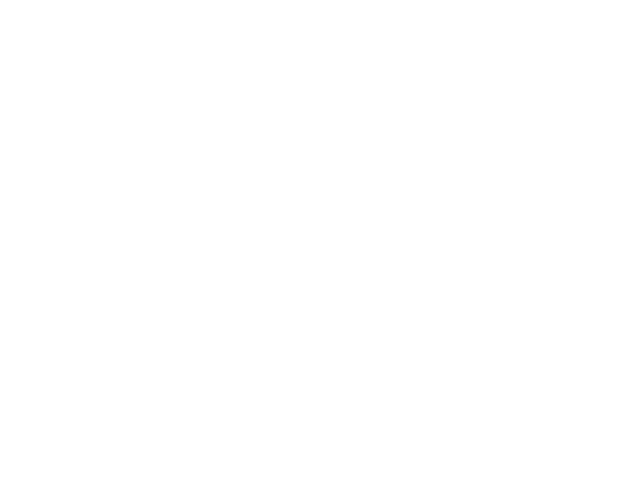

1d.
mu_GMM: 11.34 sig_GMM: 0.21
The value of the GMM criterion function: 6.505942554065515e-09
Data moments: 0.30, 0.50, 0.20
Model moments: 0.30, 0.50, 0.20



<IPython.core.display.Javascript object>


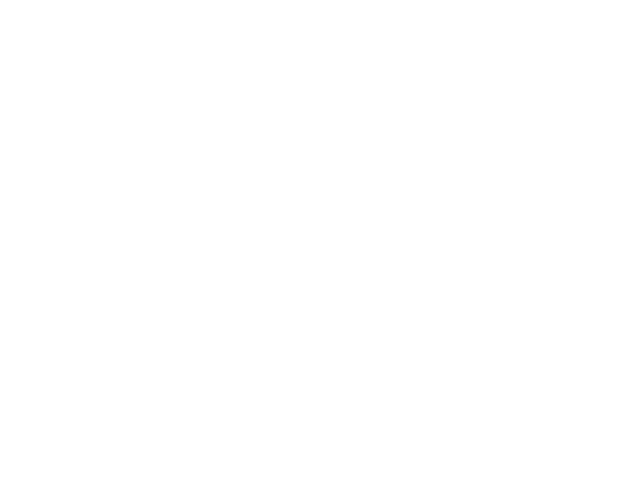

1e.
mu_GMM: 11.34 sig_GMM: 0.21
The value of the GMM criterion function: 3.601013055520852e-07
Data moments: 0.30, 0.50, 0.20
Model moments: 0.29, 0.50, 0.21

1f.
From the plots we can see there is no significant difference between models, which also applies to the comparison between data moments and model moments. From my perspective, the 2-step GMM model from (e) is the best because the customized moments are "tailored" to fit the characteristics of the data, and it works well on the graph.

2.
The GMM estimates for b0, b1, b2, b3 are 0.2516447359381598, 0.01293345092463209, 0.4005011753872412, -0.009991695557197486
The value of the criterion function: 0.00182128981702


In [12]:
# (c) 
err1 = err_vec(income, mu_GMM1, sig_GMM1, 150000, False)
VCV2 = np.dot(err1, err1.T) / income.shape[0]
W_hat2 = lin.pinv(VCV2)  

params_init = np.array([mu_GMM1, sig_GMM1])
gmm_args2 = (income, 150000, W_hat2)
results2 = opt.minimize(criterion, params_init, args=(gmm_args2),
                        method='L-BFGS-B', 
                        bounds=((1e-10, None), (1e-10, None)))

mu_GMM2, sig_GMM2 = results2.x

params_init_GMM2 = np.array([mu_GMM2, sig_GMM2])
value2 = criterion(params_init_GMM2, *gmm_args2)[0,0]

mean_model2, std_model2 = model_moments(mu_GMM2, sig_GMM2, 150000)

# Plotting
fig, ax = plt.subplots()
count, bins, ignored = plt.hist(income, 30, normed = True)
plt.xlim(0, cutoff)
plt.title('PDF of Graduate Incomes of MACSS Students')
plt.xlabel(r'Income ($)')
plt.ylabel('Density')

plt.plot(dist_income, trunc_lognorm_pdf(
           dist_income, mu_GMM1, sig_GMM1,150000),
          label='GMM: $\mu = {:.2f}, \sigma = {:.2f}$'.format(mu_GMM1,
                                                              sig_GMM1))

plt.plot(dist_income, trunc_lognorm_pdf(dist_income, mu_GMM2, sig_GMM2,
          150000),label='2-Step GMM: $\mu = {:.2f}, \sigma = {:.2f}$'.\
           format(mu_GMM2, sig_GMM2))

plt.legend(loc='best')
plt.savefig('fig_1c')
plt.close()

print('1c.')
print('mu_GMM: {:.2f}'.format(mu_GMM2), 'sig_GMM: {:.2f}'.format(
       sig_GMM2))
print('The value of the GMM criterion function: {}'.format(value2))
print('Data moments: mu: {:.2f}, std: {:.2f}'.format(mean_data, std_data))
print('Model moments: mu: {:.2f}, std: {:.2f}\n'.format(mean_model2,
                                                        std_model2))


# 1d

def data_moments3(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the three data moments for GMM
    (binpct_1, binpct_2, binpct_3).
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, test scores data
    RETURNS: bpct_1, bpct_2, bpct_3, bpct_4
    --------------------------------------------------------------------
    '''
    bpct_1_dat = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >=75000) & (xvals < 100000)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = (xvals[(xvals >=100000)].shape[0] /
                  xvals.shape[0])
   
    return bpct_1_dat, bpct_2_dat, bpct_3_dat


def model_moments3(mu, sigma, cutoff):
    '''
    --------------------------------------------------------------------
    This function computes the three model moments for GMM
    (binpct_1, binpct_2, binpct_3).
    --------------------------------------------------------------------
    INPUTS:
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    RETURNS: bpct_1_mod, bpct_2_mod, bpct_3_mod, bpct_4_mod
    --------------------------------------------------------------------
    '''
    xfx = lambda x: trunc_lognorm_pdf(x, mu, sigma, cutoff)
    # use small enough figure to lower bound 
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, 0.00001, 75000)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75000, 100000)
    # use large enough figure to upper bound
    (bpct_3_mod, bp_3_err) = intgr.quad(xfx, 100000, 1500000)  

    return bpct_1_mod, bpct_2_mod, bpct_3_mod


def err_vec3(xvals, mu, sigma, cutoff, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu, sigma, cutoff)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])

    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = 100 * ((moms_model - moms_data) / moms_data)
    
    return err_vec


def criterion3(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 3 tuple, (xvals, cutoff, W_hat)
    xvals  = (N,) vector, values of the truncated normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    W_hat  = (R, R) matrix, estimate of optimal weighting matrix
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, cutoff, W = args
    err = err_vec3(xvals, mu, sigma, cutoff, simple = True)
    crit_val = np.dot(np.dot(err.T, W), err) 
    return crit_val


W_hat_1d = np.eye(3)
gmm_args_1d = (income, cutoff, W_hat_1d)
results_1d = opt.minimize(criterion3, params_init, args=(gmm_args_1d),
                       method='TNC', bounds=((1e-10, None), (1e-10, None)))


mu_GMM_1d, sig_GMM_1d = results_1d.x

params_init_GMM_1d = np.array([mu_GMM_1d, sig_GMM_1d])
value3 = criterion3(params_init_GMM_1d, *gmm_args_1d)[0][0]

data_moment1, data_moment2, data_moment3 = data_moments3(income)
model_moment1, model_moment2,model_moment3 = model_moments3(mu_GMM_1d,
                                                            sig_GMM_1d, cutoff)

# Plot
fig, ax = plt.subplots()
count, bins, ignored = plt.hist(income, 30, normed = True)
plt.xlim(0, cutoff)
plt.title('PDF of Graduate Incomes of MACSS Students')
plt.xlabel(r'Income ($)')
plt.ylabel('Density')

plt.plot(dist_income, trunc_lognorm_pdf(dist_income, mu_GMM_1d, sig_GMM_1d,
    150000),label='GMM: $\mu = {:.2f}, \sigma = {:.2f}$'.format(mu_GMM_1d,
                                                            sig_GMM_1d))
plt.legend(loc='best')
plt.savefig('fig_1d')
plt.close()

print('1d.')
print('mu_GMM: {:.2f}'.format(mu_GMM_1d), 'sig_GMM: {:.2f}'.format(
       sig_GMM_1d))
print('The value of the GMM criterion function: {}'.format(value3))
print('Data moments: {:.2f}, {:.2f}, {:.2f}'.format(data_moment1, data_moment2,
                                        data_moment3))
print('Model moments: {:.2f}, {:.2f}, {:.2f}\n'.format(model_moment1,
                                                model_moment2, model_moment3))


# 1e

err_1e = err_vec3(income, mu_GMM_1d, sig_GMM_1d, 150000, True)
VCV_1e = np.dot(err_1e, err_1e.T) / income.shape[0]
W_hat_1e = lin.pinv(VCV_1e) 

gmm_args_1e = (income, 150000, W_hat_1e)
results_1e = opt.minimize(criterion3, params_init, args=(gmm_args_1e),
                        method='TNC', bounds=((1e-10, None), (1e-10, None)))

mu_GMM_1e, sig_GMM_1e = results_1e.x

params_init_1e = np.array([mu_GMM_1e, sig_GMM_1e])
value_1e = criterion3(params_init_1e, *gmm_args_1e)[0][0]

dm_1e1, dm_1e2, dm_1e3 = data_moments3(income)
mm_1e1,mm_1e2, mm_1e3 = model_moments3(mu_GMM_1e, sig_GMM_1e, 150000)



if True:
    fig, ax = plt.subplots()
    count, bins, ignored = plt.hist(income, 30, normed = True)
    plt.xlim(0, cutoff)
    plt.title('PDF of Graduate Incomes of MACSS Students')
    plt.xlabel(r'Income ($)')
    plt.ylabel('Density')

    plt.plot(dist_income, trunc_lognorm_pdf(dist_income, mu_GMM_1d, sig_GMM_1d,
        150000),label='GMM: $\mu = {:.2f}, \sigma = {:.2f}$'.format(mu_GMM_1d,
                                                                sig_GMM_1d))

    plt.plot(dist_income, trunc_lognorm_pdf(dist_income, mu_GMM_1e, sig_GMM_1e,
              150000),label='2-Step GMM: $\mu = {:.2f}, \sigma = {:.2f}$'.\
               format(mu_GMM_1e, sig_GMM_1e))
    
    plt.legend(loc='best')
    plt.savefig('fig_1e')
    plt.close()

print('1e.')
print('mu_GMM: {:.2f}'.format(mu_GMM_1e), 'sig_GMM: {:.2f}'.format(
       sig_GMM_1e))
print('The value of the GMM criterion function: {}'.format(value_1e))
print('Data moments: {:.2f}, {:.2f}, {:.2f}'.format(dm_1e1, dm_1e2, dm_1e3))
print('Model moments: {:.2f}, {:.2f}, {:.2f}\n'.format(mm_1e1,mm_1e2, mm_1e3))


print('1f.')
print('From the plots we can see there is no significant difference between models, which also applies to the comparison between data moments and model moments. From my perspective, the 2-step GMM model from (e) is the best because the customized moments are "tailored" to fit the characteristics of the data, and it works well on the graph.\n')


# Problem 2

sick = np.loadtxt('sick.txt', skiprows=1, delimiter=',')

def sick_data_moments(data):
    data_moments_ls = []
    
    for i in range(data.shape[0]):
        data_value = data[i,0]
        data_moments_ls.append(data_value)
    
    return data_moments_ls

def sick_model_moments(data, b0, b1, b2, b3):
    model_moments_ls = []
    
    for i in range(data.shape[0]):
        age_i = data[i,1]
        children_i= data[i,2]
        avgtemp_winter_i = data[i,3]
        model_value = b0 + b1 * age_i + b2 * children_i + b3 * avgtemp_winter_i
        model_moments_ls.append(model_value)
    
    return model_moments_ls

def sick_err_vec(data, b0, b1, b2, b3):
    sick_values = sick_data_moments(data)
    moms_data = np.array(sick_values)
    expected_values = sick_model_moments(data, b0, b1, b2, b3)
    moms_model = np.array(expected_values)
    err_vec = moms_model - moms_data
    
    return err_vec

def sick_criterion(params, *args):
    b0,b1,b2,b3 = params
    data, sick_cutoff, W = args
    err = sick_err_vec(data, b0, b1, b2, b3)
    crit_val = np.dot(np.dot(err.T, W), err) 

    return crit_val

b0_init, b1_init, b2_init, b3_init = 0.2, 0.2, 0.3, 0.3

sick_params_init = np.array([b0_init,b1_init,b2_init,b3_init])
sick_bnds = ((None, None),(None, None), (None, None), (None, None))
sick_W_hat = np.eye(200)
sick_args = (sick, np.inf, sick_W_hat) 
sick_results = opt.minimize(sick_criterion, sick_params_init, args=(sick_args),
                       method='L-BFGS-B', bounds=sick_bnds)

b0_GMM, b1_GMM, b2_GMM, b3_GMM = sick_results.x

sick_params_init = np.array([b0_GMM, b1_GMM, b2_GMM, b3_GMM])
value_sick = sick_criterion(sick_params_init, *sick_args)

print('2.')
print('The GMM estimates for b0, b1, b2, b3 are {}, {}, {}, {}'.format(b0_GMM,
        b1_GMM, b2_GMM, b3_GMM))
print('The value of the criterion function:', value_sick)